In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error



import warnings
%matplotlib inline
pd.options.display.max_rows = 1000
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings("ignore")

In [2]:
house_pricing=pd.read_csv('train.csv')

house_pricing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
# dropping columns which have > 30% NULL values

def getPerctNULLValues(column):
    return (house_pricing[column].isnull().sum()/len(house_pricing))*100

null_columns=[column for column in house_pricing.columns if getPerctNULLValues(column)>30]
house_pricing.drop(null_columns, inplace=True, axis=1)

In [4]:
#percentage of null values in remaining columns (if any)
columns_having_nulls=[(column,getPerctNULLValues(column),house_pricing[column].isnull().sum(), house_pricing[column].nunique()) 
            for column in house_pricing.columns if getPerctNULLValues(column)>0]

df_nulls=pd.DataFrame(columns_having_nulls, columns=['Attribute','Null%','No Of Null Rows','Unique Values'])
df_nulls.sort_values(['No Of Null Rows'], ascending=False)

,Attribute,Null%,No Of Null Rows,Unique Values
0,LotFrontage,17.739726,259,110
9,GarageType,5.547945,81,6
10,GarageYrBlt,5.547945,81,97
11,GarageFinish,5.547945,81,3
12,GarageQual,5.547945,81,5
13,GarageCond,5.547945,81,5
5,BsmtExposure,2.602740,38,4
7,BsmtFinType2,2.602740,38,6
3,BsmtQual,2.534247,37,4
4,BsmtCond,2.534247,37,4


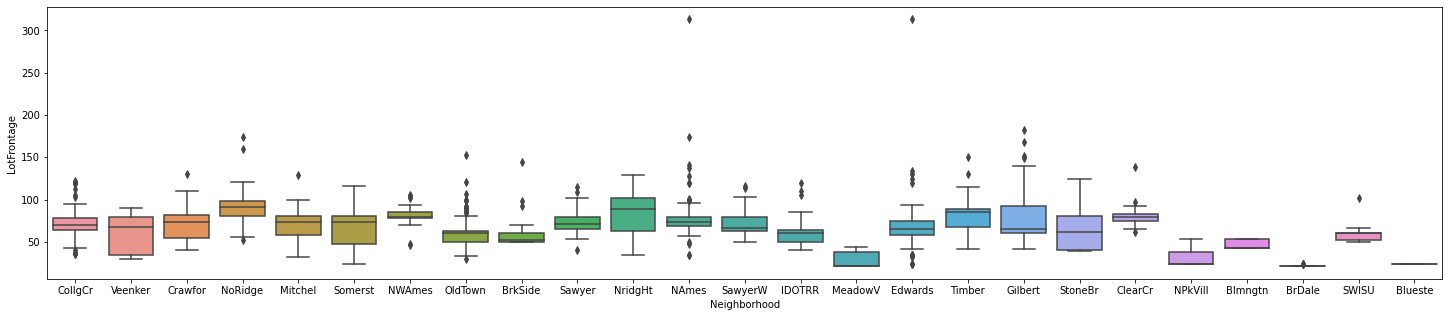

In [5]:
#LotFrontage null values can be filled in as per the neighborhood values
plt.figure(figsize=(25,5))
sns.boxplot(data=house_pricing, x='Neighborhood', y='LotFrontage')
plt.show()


In [6]:
#Since there is variation in data wrt Neighborhood, hence the mean based on group by Neighborhood would be good to fill Null values
house_pricing['LotFrontage']=house_pricing.groupby('Neighborhood').LotFrontage.transform(lambda x: x.fillna(x.mean()))

In [7]:
house_pricing[house_pricing['GarageCars']==0][['GarageType','GarageFinish','GarageQual','GarageCond','GarageCars']].head()

,GarageType,GarageFinish,GarageQual,GarageCond,GarageCars
39,NaN,NaN,NaN,NaN,0
48,NaN,NaN,NaN,NaN,0
78,NaN,NaN,NaN,NaN,0
88,NaN,NaN,NaN,NaN,0
89,NaN,NaN,NaN,NaN,0


In [8]:
#dropping year for garage and electrical
house_pricing.drop(['GarageYrBlt','Electrical','Id','MoSold'], axis=1, inplace=True)

In [9]:
garage_nullvalues=['GarageType','GarageFinish','GarageQual','GarageCond']
house_pricing[garage_nullvalues]=house_pricing[garage_nullvalues].fillna('No Garage')

In [10]:
# treating basement null values
basement_nullvalues=['BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond','BsmtFinType1']
house_pricing[basement_nullvalues]=house_pricing[basement_nullvalues].fillna('Not Applicable')

In [11]:
# treating mansonary null values
house_pricing['MasVnrType']= house_pricing['MasVnrType'].fillna("None")
house_pricing['MasVnrArea']= house_pricing['MasVnrArea'].fillna(0)

In [12]:
house_pricing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [13]:
# label encoding the Built Year and Remodeled Year
# 1. <1900 - Very Old
# 2. <2000 - Old
# 3. Remaining - New

def applyYearLabel(year):
    if year < 1900:
        return 'Very Old'
    elif year < 2000:
        return 'Old'
    else:
        return 'New'

house_pricing.YearBuilt = house_pricing.YearBuilt.transform(lambda x: applyYearLabel(x))
house_pricing.YearRemodAdd = house_pricing.YearRemodAdd.transform(lambda x: applyYearLabel(x))

<Figure size 1080x360 with 0 Axes>

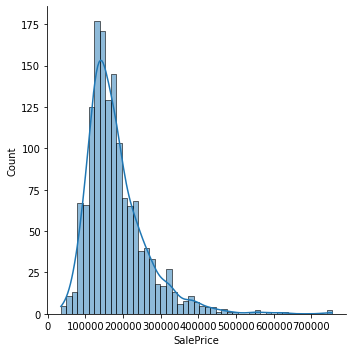

In [14]:
# Distribution of Target Variable

plt.figure(figsize=(15,5))
sns.displot(house_pricing['SalePrice'], kde=True)
plt.show()

In [15]:
#Plot shows the disctribution is skewed
print("the skewness of the target feature is %f "% house_pricing["SalePrice"].skew())
print("the kurtosis of the target feature is %f "% house_pricing["SalePrice"].kurt())

the skewness of the target feature is 1.882876 
the kurtosis of the target feature is 6.536282 


In [16]:
numerical_features=house_pricing.select_dtypes(exclude='object')
categorical_features=house_pricing.select_dtypes(include='object')


<Figure size 1080x360 with 0 Axes>

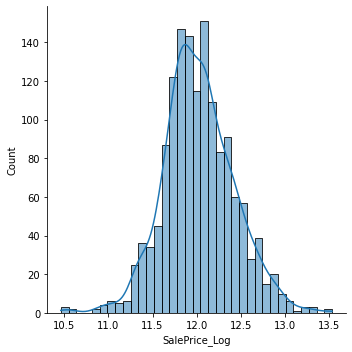

In [17]:
# transforming target variable
numerical_features['SalePrice_Log']=numerical_features.SalePrice.transform(lambda x: np.log(x))
numerical_features.drop('SalePrice', axis=1, inplace=True)

# After transformation - Distribution of Target Variable

plt.figure(figsize=(15,5))
sns.displot(numerical_features['SalePrice_Log'], kde=True)
plt.show()

In [18]:
# Checking for Skewness for numerical data and then if required need to apply scaling

skew_data= numerical_features.iloc[:,:-1].apply(lambda x: x.skew())
skew_data.sort_values(ascending=False)

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
MasVnrArea        2.677616
OpenPorchSF       2.364342
LotFrontage       2.161425
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
MSSubClass        1.407657
1stFlrSF          1.376757
GrLivArea         1.366560
BsmtUnfSF         0.920268
2ndFlrSF          0.813030
OverallCond       0.693067
TotRmsAbvGrd      0.676341
HalfBath          0.675897
Fireplaces        0.649565
BsmtFullBath      0.596067
OverallQual       0.216944
BedroomAbvGr      0.211790
GarageArea        0.179981
YrSold            0.096269
FullBath          0.036562
GarageCars       -0.342549
dtype: float64

In [19]:
#selecting columns for transformation

numericalCol_toBeTransformed_index=skew_data[skew_data> -0.5].index

# Transforming using Log

In [20]:
for index in numericalCol_toBeTransformed_index:
    numerical_features[index]=np.log1p(numerical_features[index])

In [21]:
numerical_features.apply(lambda x: x.skew()).sort_values(ascending=False)

PoolArea         14.363102
3SsnPorch         7.734975
LowQualFinSF      7.460317
MiscVal           5.170704
BsmtHalfBath      3.933064
KitchenAbvGr      3.869414
ScreenPorch       3.150409
BsmtFinSF2        2.523694
EnclosedPorch     2.112275
HalfBath          0.566168
MasVnrArea        0.503532
BsmtFullBath      0.419213
2ndFlrSF          0.289643
MSSubClass        0.248997
Fireplaces        0.182083
WoodDeckSF        0.153537
SalePrice_Log     0.121335
YrSold            0.095475
1stFlrSF          0.080114
GrLivArea        -0.006140
OpenPorchSF      -0.023397
TotRmsAbvGrd     -0.058258
LotArea          -0.137404
OverallCond      -0.254015
FullBath         -0.394635
OverallQual      -0.590977
BsmtFinSF1       -0.618410
LotFrontage      -0.920782
BedroomAbvGr     -1.233677
GarageCars       -1.370219
BsmtUnfSF        -2.186504
GarageArea       -3.482604
TotalBsmtSF      -5.154670
dtype: float64

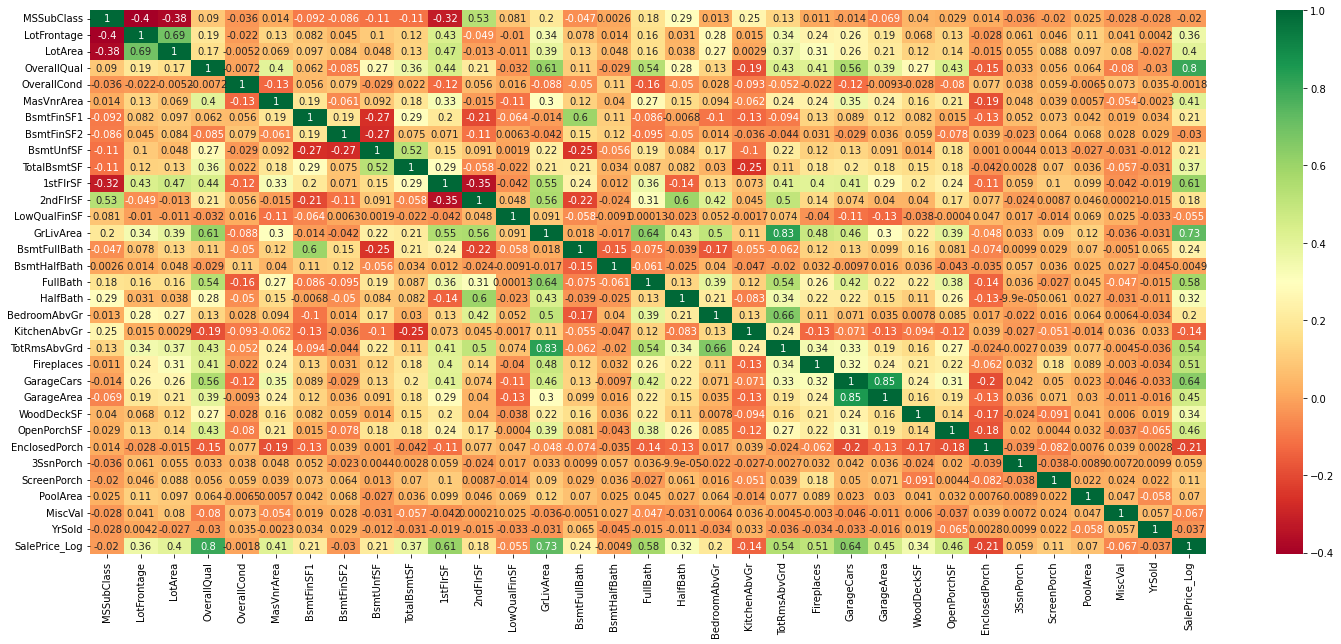

In [22]:
# correlation of numerical columns with the Target Variable
numerical_corr=numerical_features.corr()

plt.figure(figsize=(25,10))
sns.heatmap(numerical_corr, annot=True,cmap="RdYlGn")
plt.show()

In [23]:
#Plotting Categorial features wrt SalePrice
categorical_features.shape

(1460, 39)

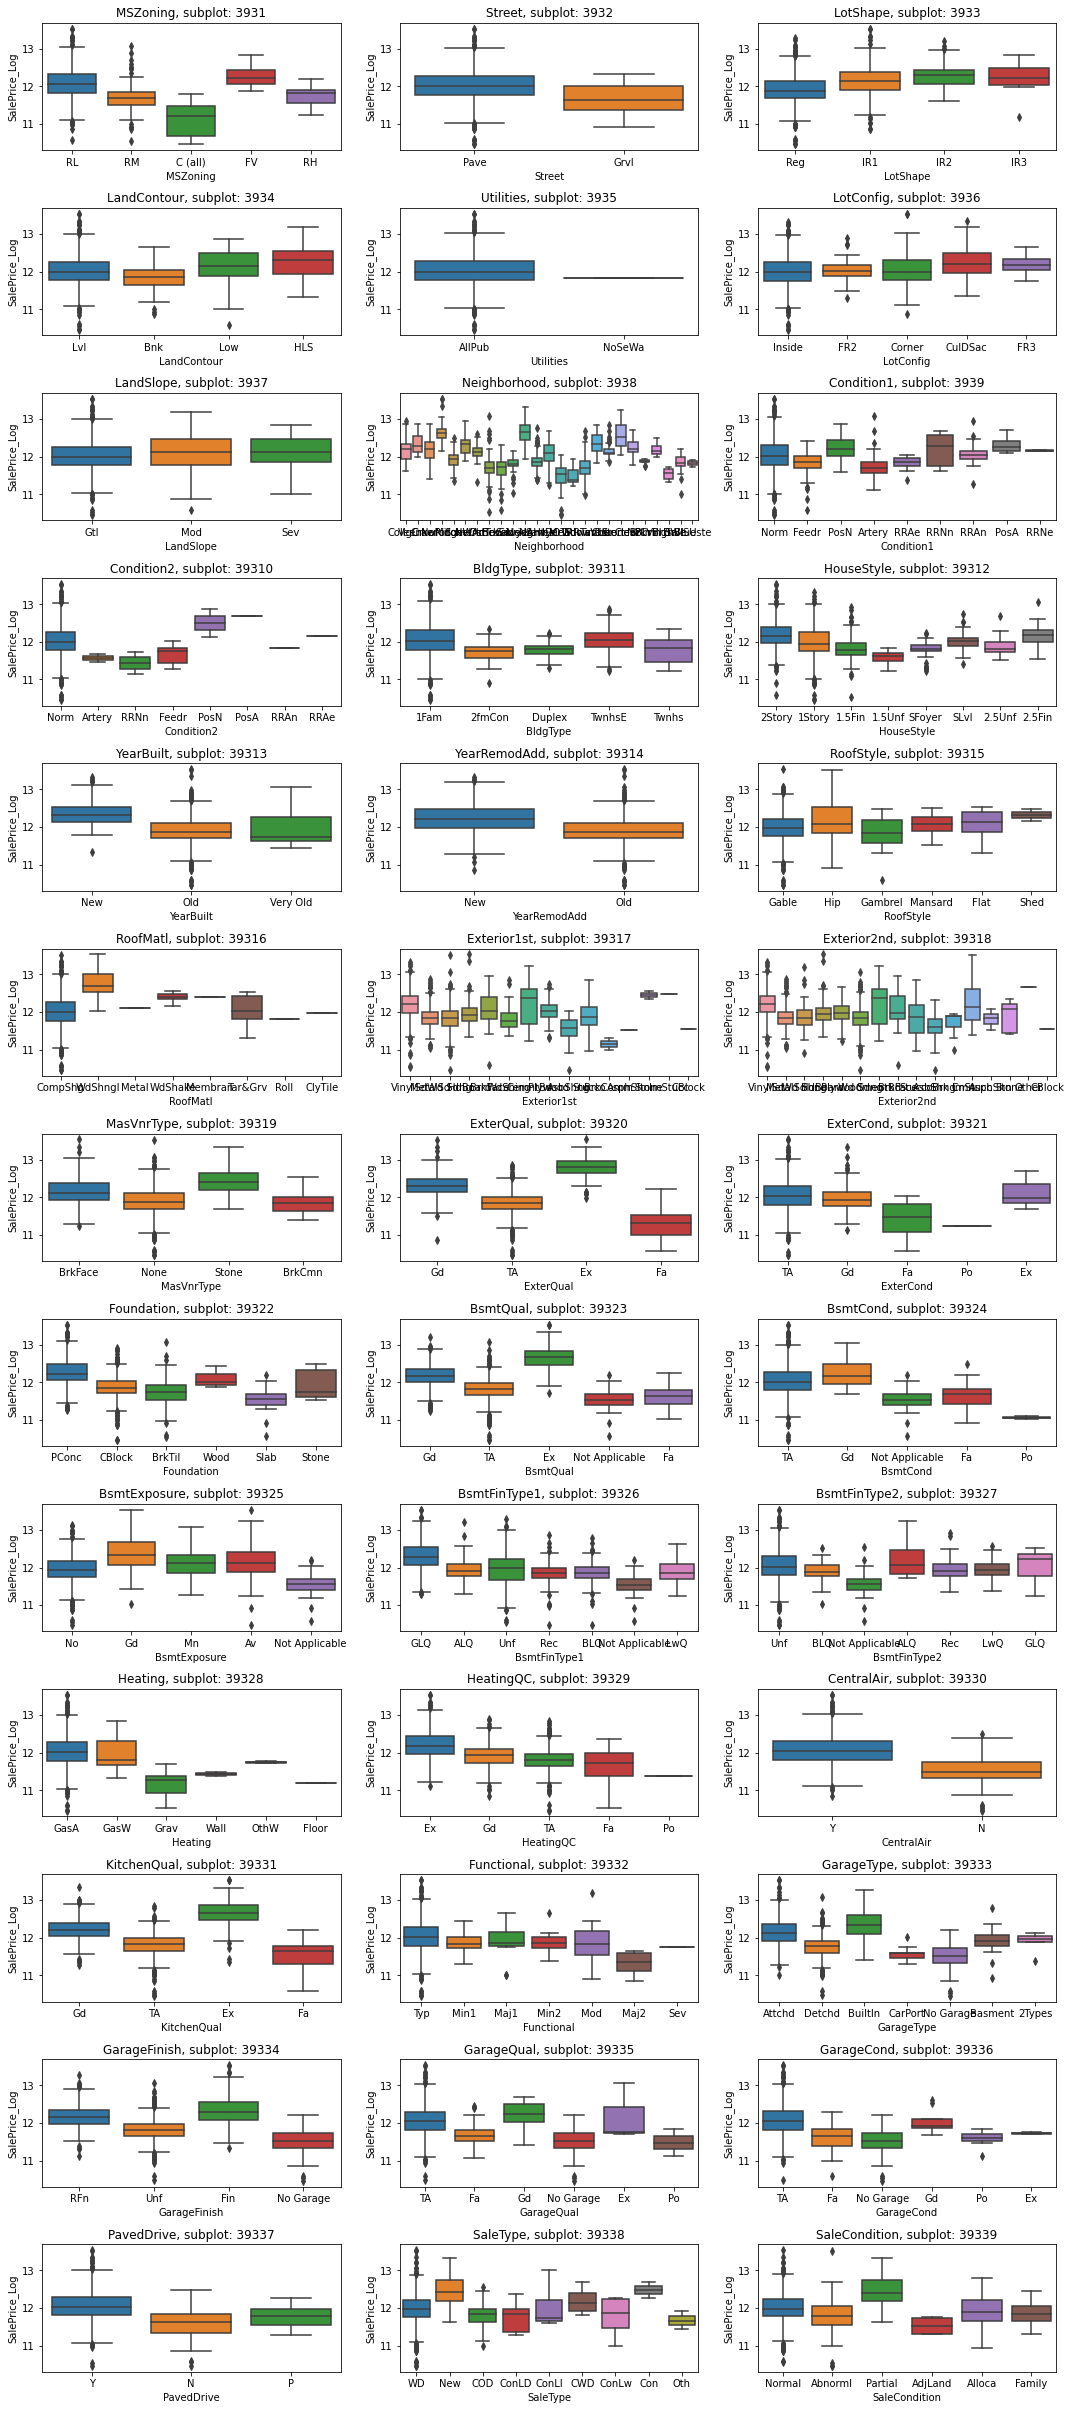

In [24]:
rows=categorical_features.shape[1]
columns=3
index=1

fig = plt.figure(figsize=(50,40))
fig.set_size_inches(15, 100)

for i in categorical_features:
    plt.subplot(rows, columns, index)
    plt.title('{}, subplot: {}{}{}'.format(i, rows,columns,index))
    plt.xlabel(i)
    sns.boxplot(categorical_features[i], numerical_features['SalePrice_Log'])
    index = index + 1

plt.tight_layout()
plt.show()


## Since there is variations in almost all feature variable, lets consider all the variables in model.

# Encoding Categorial feature via- One Hot Encoding

In [25]:
encoded_categorical_features=pd.get_dummies(categorical_features, drop_first=True)
encoded_categorical_features.shape

(1460, 204)

# Final Dataset for modelling

In [26]:
final_dataset= pd.concat([numerical_features, encoded_categorical_features], axis=1)
final_dataset.shape

(1460, 237)

In [27]:
final_dataset.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice_Log,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,YearBuilt_Old,YearBuilt_Very Old,YearRemodAdd_Old,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Not Applicable,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Not Applicable,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Not Applicable,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Not Applicable,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Not Applicable,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No Garage,GarageFinish_No Garage,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_No Garage,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_No Garage,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,2.079442,1.791759,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,0.0,7.444833,0.693147,0.000000,1.098612,0.693147,1.3

# Split dependent and target variable

In [28]:
X= final_dataset.drop('SalePrice_Log', axis=1)
y= final_dataset.pop('SalePrice_Log')

print('X Shape -', X.shape)
print('y Shape -', y.shape)

X Shape - (1460, 236)
y Shape - (1460,)


In [29]:
# Splitting dataset into Train and Test

from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state =1)

print('X train shape',X_train.shape)
print('X test shape',X_train.shape)
print('y train shape',y_train.shape)
print('y test shape',y_test.shape)

X train shape (1022, 236)
X test shape (1022, 236)
y train shape (1022,)
y test shape (438,)


# Ridge 
## Regression

In [31]:
params= {'alpha':[0.0005,0.001,0.01,0.1,0.2,0.4,0.5,0.7,0.8,1,3,4,5,6,7,8,9,10,15,20]}

folds=10

In [32]:
lm_ridge=Ridge()

lm_ridge_grd=GridSearchCV(estimator=lm_ridge, param_grid=params, cv=folds, return_train_score=True, verbose=1)
lm_ridge_grd.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.0005, 0.001, 0.01, 0.1, 0.2, 0.4, 0.5, 0.7,
                                   0.8, 1, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]},
             return_train_score=True, verbose=1)

In [33]:
print("The best value of Alpha is: ",lm_ridge_grd.best_params_,lm_ridge_grd.best_score_)

The best value of Alpha is:  {'alpha': 8} 0.87808080168685


In [34]:
ridge= Ridge(lm_ridge_grd.best_params_['alpha'])
ridge.fit(X_train, y_train)
print(ridge.coef_)

[-1.86643124e-02 -1.55824427e-02  7.43656487e-02  2.10230565e-01
  1.76284677e-01 -6.37336777e-04  1.11048319e-02  1.86489676e-03
 -4.57915362e-03  4.02944814e-02  1.20114895e-01  1.19032741e-02
  9.76315768e-03  2.07175676e-01  2.18993485e-02  5.08391540e-03
  7.44664575e-02  2.98564631e-02  2.97030027e-02 -4.88783655e-02
  5.89014227e-02  5.15718388e-02  1.10236854e-01  1.79173285e-02
  4.38549380e-03  4.87516568e-03  4.65047171e-03  4.59920276e-03
  7.56464661e-03 -2.65939399e-02 -3.17981874e-03 -2.42528780e-04
  3.38368938e-02  4.35554096e-02  2.08843470e-02 -1.64879212e-02
  8.68043506e-03  2.86163619e-02 -4.02894933e-02 -3.39314882e-03
  7.46015196e-02 -1.21072313e-02  6.09534799e-02 -2.77267743e-02
  2.47535014e-02 -2.23789453e-02 -2.02113081e-02 -1.20521295e-02
  2.10464411e-02 -6.83138943e-03  1.31342742e-03  8.34503743e-03
  8.40957848e-03  2.24659053e-02 -1.98406213e-02  8.74196053e-02
 -9.77027199e-02 -3.75135815e-02 -4.28755549e-02 -5.16607328e-02
 -2.83916108e-02 -4.55634

## Prediction

In [35]:
y_pred_train_ridge=ridge.predict(X_train)
y_pred_test_ridge=ridge.predict(X_test)

In [36]:
ridge_pred_metrics=[]

r2_train_ridge=r2_score(y_train, y_pred_train_ridge)
print("R2 Train- ",r2_train_ridge)
ridge_pred_metrics.append(r2_train_ridge)

r2_test_ridge=r2_score(y_test, y_pred_test_ridge)
print("R2 Test- ",r2_test_ridge)
ridge_pred_metrics.append(r2_test_ridge)

rss_train_ridge=np.sum(np.square(y_train-y_pred_train_ridge))
print("RSS Train- ",rss_train_ridge)
ridge_pred_metrics.append(rss_train_ridge)

rss_test_ridge=np.sum(np.square(y_test-y_pred_test_ridge))
print("RSS Test- ",rss_test_ridge)
ridge_pred_metrics.append(rss_test_ridge)


mss_train_ridge=mean_squared_error(y_train, y_pred_train_ridge)
print("MSS Train- ",mss_train_ridge)
ridge_pred_metrics.append(mss_train_ridge)

mss_test_ridge=mean_squared_error(y_test, y_pred_test_ridge)
print("MSS Test- ",mss_test_ridge)
ridge_pred_metrics.append(mss_test_ridge)

R2 Train-  0.9259375610825158
R2 Test-  0.8913182762527527
RSS Train-  11.092480626040997
RSS Test-  8.996390254216466
MSS Train-  0.010853699242701563
MSS Test-  0.020539703776749924


# Lasso 
## Regression

In [37]:
lm_lasso=Lasso()

lm_lasso_grd=GridSearchCV(estimator=lm_lasso, param_grid=params, cv=folds, return_train_score=True, verbose=1)
lm_lasso_grd.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.0005, 0.001, 0.01, 0.1, 0.2, 0.4, 0.5, 0.7,
                                   0.8, 1, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]},
             return_train_score=True, verbose=1)

In [38]:
print("The best value of Alpha is: ",lm_lasso_grd.best_params_,lm_lasso_grd.best_score_)

The best value of Alpha is:  {'alpha': 0.001} 0.8807310526295116


In [39]:
lasso= Lasso(alpha=lm_lasso_grd.best_params_['alpha'])
lasso.fit(X_train, y_train)

Lasso(alpha=0.001)

In [40]:
lasso.coef_

array([-2.17737829e-02, -0.00000000e+00,  6.77244618e-02,  3.24977623e-01,
        2.20917884e-01,  7.61086110e-04,  1.09887835e-02, -3.14112653e-04,
       -2.52302119e-03,  2.02091004e-02,  5.19922487e-03, -5.19439118e-03,
       -2.24748660e-03,  4.20983632e-01,  2.26517544e-02,  0.00000000e+00,
        3.97946755e-02,  1.45505832e-02,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  4.23300577e-02,  1.33961248e-01, -0.00000000e+00,
        5.65914051e-03,  4.70956137e-03,  1.55654823e-03,  1.95130582e-04,
        7.48083781e-03, -2.10740092e-02, -3.95242278e-03, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.60791068e-02,
        0.00000000e+00,  1.25771709e-02, -0.00000000e+00, -1.05308894e-03,
        3.20528532e-02,  0.00000000e+00,  3.76418165e-02, -0.00000000e+00,
        3.04414597e-02, -0.00000000e+00, -0.00000000e+00, -2.88822275e-03,
        3.41681470e-03, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

## Prediction

In [41]:
y_pred_train_lasso=lasso.predict(X_train)
y_pred_test_lasso=lasso.predict(X_test)

In [42]:
lasso_pred_metrics=[]

r2_train_lasso=r2_score(y_train, y_pred_train_lasso)
print("R2 Train- ",r2_train_lasso)
lasso_pred_metrics.append(r2_train_lasso)

r2_test_lasso=r2_score(y_test, y_pred_test_lasso)
print("R2 Test- ",r2_test_lasso)
lasso_pred_metrics.append(r2_test_lasso)

rss_train_lasso=np.sum(np.square(y_train-y_pred_train_lasso))
print("RSS Train- ",rss_train_lasso)
lasso_pred_metrics.append(rss_train_lasso)

rss_test_lasso=np.sum(np.square(y_test-y_pred_test_lasso))
print("RSS Test- ",rss_test_lasso)
lasso_pred_metrics.append(rss_test_lasso)


mss_train_lasso=mean_squared_error(y_train, y_pred_train_lasso)
print("MSS Train- ",mss_train_lasso)
lasso_pred_metrics.append(mss_train_lasso)

mss_test_lasso=mean_squared_error(y_test, y_pred_test_lasso)
print("MSS Test- ",mss_test_lasso)
lasso_pred_metrics.append(mss_test_lasso)

R2 Train-  0.9111606352666328
R2 Test-  0.892665113138026
RSS Train-  13.305650563743797
RSS Test-  8.884902601914684
MSS Train-  0.013019227557479253
MSS Test-  0.02028516575779608


# Comparison Ridge vs Lasso

In [43]:
# Tabular representation for metrics

regr_table={'Metric':['R2 Scrore Train','R2 Score Test','RSS Train','RSS Test','MSS Train','MSS Test'],
             'Ridge Regression':ridge_pred_metrics,
             'Lasso Regression': lasso_pred_metrics}

df=pd.DataFrame(regr_table, columns=['Metric','Ridge Regression','Lasso Regression'])

print(df)
print("Alpha Value for Ridge Regression-", lm_ridge_grd.best_params_['alpha'])
print("Alpha Value for Lasso Regression-", lm_lasso_grd.best_params_['alpha'])

            Metric  Ridge Regression  Lasso Regression
0  R2 Scrore Train          0.925938          0.911161
1    R2 Score Test          0.891318          0.892665
2        RSS Train         11.092481         13.305651
3         RSS Test          8.996390          8.884903
4        MSS Train          0.010854          0.013019
5         MSS Test          0.020540          0.020285
Alpha Value for Ridge Regression- 8
Alpha Value for Lasso Regression- 0.001


In [44]:
## Comparing Coefficients from the Regressions

betas=pd.DataFrame(index=X_train.columns)
betas.rows=X.columns
betas['Ridge']=ridge.coef_
betas['Lasso']=lasso.coef_

In [45]:
# Conclusion- from the metrics Lasso Model has clear advantage over Ridge as its has higher R2 score (0.91 and 0.89 for train and Test model respectively)
# the difference between the test and train data score is less compared to Ridge. Hence there is less overfitting in latter model

In [46]:
# dropping betas with 0 value
final_betas_lasso= betas[round(betas['Lasso'],3)!=0.000][['Lasso']].apply(lambda x: round(x,3))
final_betas_lasso[['Lasso']].sort_values('Lasso',ascending=False).head()

,Lasso
GrLivArea,0.421
OverallQual,0.325
OverallCond,0.221
GarageCars,0.134
Neighborhood_StoneBr,0.128


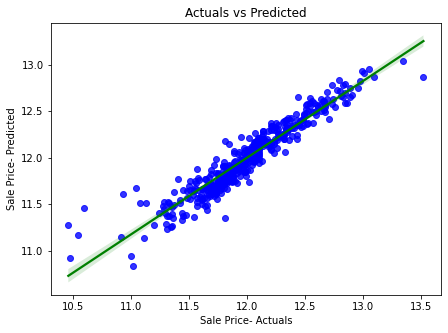

In [47]:
plt.figure(figsize=(7,5))
sns.regplot(x=y_test, y=y_pred_test_lasso, scatter_kws={"color": "blue"}, line_kws={"color": "green"})
plt.xlabel('Sale Price- Actuals')
plt.ylabel('Sale Price- Predicted')
plt.title('Actuals vs Predicted')
plt.show()

# Feature Importance

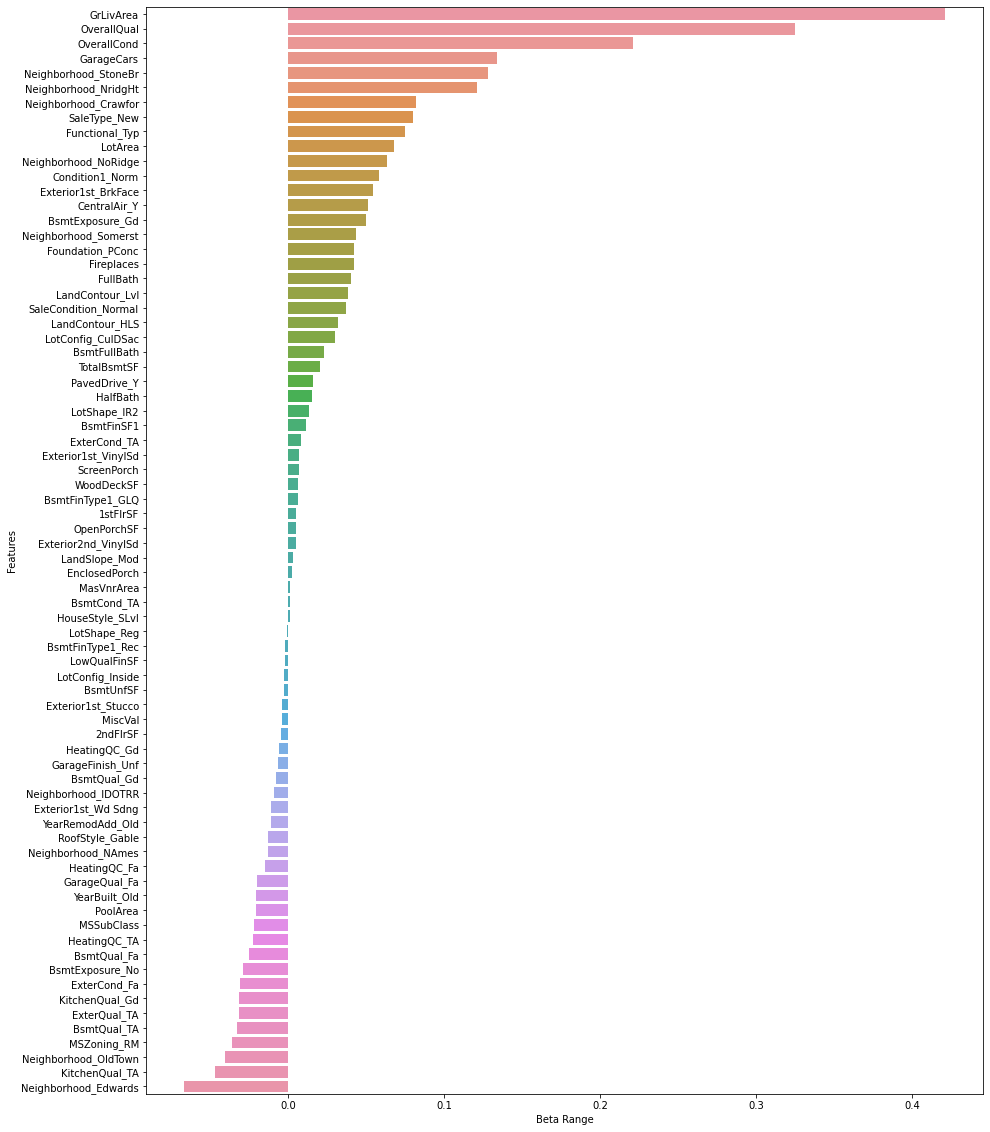

In [48]:
sorted_final_betas= final_betas_lasso.sort_values('Lasso', ascending=False)
plt.figure(figsize=(15,20))
sns.barplot(data=sorted_final_betas, y= sorted_final_betas.index, x= sorted_final_betas['Lasso'])
plt.xlabel('Beta Range')
plt.ylabel('Features')
plt.show()


# Conclusion

In [49]:
conclusion_table={'Positive Effect on Sale Price':['Area of the Living Room in ground floor',
                                                   'Overall quality of material and finish of house',
                                                   'Overall condition of the house',
                                                   'Size of garage in terms of cars that can be accommodated',
                                                   'Locations like Stone Brook, Northridge Heights, Crawford',
                                                   'Newly constructed house and sold',
                                                   'Area of the Lot'],
                   'Negative Impact on Sale Price':['Average Kitchen Quality',
                                                    'Residential if that has medium density',
                                                    'Locations like Edwards, Old Town',
                                                    'Basement quality- If the height is in range of 80-89 inches',
                                                    'Average quality of external material is used',
                                                    'If the condition of exterior is Average',
                                                    'If  kitchen quality is not so good.']}

conclusion=pd.DataFrame(conclusion_table, columns=['Positive Effect on Sale Price','Negative Impact on Sale Price'])
conclusion

,Positive Effect on Sale Price,Negative Impact on Sale Price
0,Area of the Living Room in ground floor,Average Kitchen Quality
1,Overall quality of material and finish of house,Residential if that has medium density
2,Overall condition of the house,"Locations like Edwards, Old Town"
3,Size of garage in terms of cars that can be ac...,Basement quality- If the height is in range of...
4,"Locations like Stone Brook, Northridge Heights...",Average quality of external material is used
5,Newly constructed house and sold,If the condition of exterior is Average
6,Area of the Lot,If kitchen quality is not so good.
